<img src="img/mvp_art.png" width=200 height=200 />

# CMSC320 Final Project Prototype
## Predicting the Most Valuable Player
---

In [1]:
# Enter into terminal to update website: jupyter nbconvert --to html index.ipynb
# import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import selenium.webdriver as webdriver
import contextlib2
import unidecode as uni
sns.set(style="darkgrid")

## Finding MVP Candidates
---

In [2]:
def rename_unnamed(df):
    for i, columns in enumerate(df.columns.levels):
        columns_new = columns.tolist()
        for j, row in enumerate(columns_new):
            if 'Unnamed: ' in row:
                columns_new[j] = ''
        df = df.rename(columns=dict(zip(columns.tolist(), columns_new)),
                           level=i)
    return df
def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: "".join(x))
    return df

In [3]:
votes = {}
for i in range(0,19):
    data = pd.read_html('https://www.basketball-reference.com/awards/awards_' + str(i+2001) + '.html')[0]
    data = rename_unnamed(data)
    data = collapse_columns(data)
    data = data.loc[:4, ['Rank', 'Player', 'Tm', 'VotingShare']]
    votes[i+2001] = data

## MVP Candidate Database Builder
---

    # subprocess.call(['rm','-rf','MVP'])
    # subprocess.call(['mkdir','MVP'])
    for year in votes:
        for name in votes[year]['Player']:
            if not (os.path.isdir('MVP/' + str(year) + '/' + name)):
                if not name in (['Isaiah Thomas', 'Anthony Davis']):
                    link = str.lower(name.split()[1])[:1] + '/' + \
                            uni.unidecode(str.lower(name.split()[1]).replace("'", ""))[:5] + \
                                str.lower(name.split()[0]).replace("'", "")[:2] + '01'
                else:
                    link = str.lower(name.split()[1])[:1] + '/' + \
                            uni.unidecode(str.lower(name.split()[1]).replace("'", ""))[:5] + \
                                str.lower(name.split()[0]).replace("'", "")[:2] + '02'

                @contextlib2.contextmanager
                def quitting(thing):
                    yield thing
                    thing.quit()
                with quitting(webdriver.Firefox()) as driver:
                    link = 'https://www.basketball-reference.com/players/' + link + '.html' 
                    driver.get(link)
                    content = driver.page_source
                    with open('/tmp/out.html', 'wb') as f:
                        f.write(content.encode('utf-8'))
                    data = pd.read_html(content)

                path1 = 'MVP/' + str(year)
                path2 = 'MVP/' + str(year) + '/' + name
                subprocess.call(['mkdir', path1])
                subprocess.call(['mkdir', path2])

                pergame = data[18]
                pergame.replace('Did Not Play\xa0(injury—ACL)',np.nan,inplace=True)
                if pergame['3P%'].isnull().any():
                    pergame.drop(columns='3P%',inplace=True)
                pergame.dropna(inplace=True)
                pergame['Season'] = [int(str(x).split('-')[0])+1 for x in pergame['Season']]
                pergame['Age'] = pergame['Age'].astype(int)
                pergame['G'] = pergame['G'].astype(int)
                pergame['GS'] =pergame['GS'].astype(int)
                pergame = pergame[pergame['Season'] == year]
                pergame.reset_index(inplace=True,drop=True)
                pergame = pergame.loc[:, ['Season', 'Tm', 'Pos', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 
                                        'FG%', '3P%', 'eFG%', 'FT%']]
                # pergame.to_csv(path2 + '/Table_PerGame.csv')
                pergame.to_csv(path2 + '/PerGame.csv')

                advanced = data[22]
                if 'Unnamed: 19' in advanced.columns:
                    advanced.drop(columns=['Unnamed: 19', 'Unnamed: 24'],inplace=True)
                advanced.replace('Did Not Play\xa0(injury—ACL)',np.nan,inplace=True)
                advanced.dropna(inplace=True)
                advanced['Season'] = [int(str(x).split('-')[0])+1 for x in advanced['Season']]
                advanced['Age'] = advanced['Age'].astype(int)
                advanced['G'] = advanced['G'].astype(int)
                advanced = advanced[advanced['Season'] == year]
                advanced.reset_index(inplace=True,drop=True)
                advanced = advanced.loc[:, ['Season', 'Tm', 'Pos', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'TRB%', 
                                            'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 
                                            'OBPM', 'DBPM', 'BPM', 'VORP']]
                # advanced.to_csv(path2 + '/Table_Advanced.csv')
                advanced.to_csv(path2 + '/Advanced.csv')

In [4]:
per_game = {}
advanced = {}
for year in votes:
    for name in votes[year]['Player']:
        path = 'MVP/' + str(year) + '/' + name
        per_game[(name,year)] = pd.read_csv(path + '/' + 'Table_PerGame.csv').drop(columns='Unnamed: 0')
        advanced[(name,year)] = pd.read_csv(path + '/' + 'Table_Advanced.csv').drop(columns='Unnamed: 0')

## MVP Candidate Teams
___

    for year in votes:
        i = 0
        for team in votes[year]['Tm']:
            if team == 'NOP':
                team = 'NOH'
            name = votes[year]['Player'][i]
    #         if not (os.path.isfile('MVP/' + str(year) + '/' + name + '/Team.csv')):
            table = pd.read_html('https://www.basketball-reference.com/teams/' + team + 
                                 '/stats_per_game_totals.html')[0]
            table.replace('Season', '0000-00', inplace=True)
            table['Season'] = [int(str(x).split('-')[0])+1 for x in table['Season']]
            table = table[table['Season'] == year]
            table['Win_Pct'] = table['W'].astype(int)/table['G'].astype(int)
            table = table.loc[:, ['Season', 'Tm', 'W', 'L', 'Win_Pct', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 
                                  'FG%', '3P%', 'FT%']]
            table.to_csv('MVP/' + str(year) + '/' + name + '/Team.csv')
            i += 1

In [5]:
team_data = {}
for year in votes:
    i = 0
    for team in votes[year]['Tm']:
        name = votes[year]['Player'][i]
        team_data[(name,year)] = pd.read_csv('MVP/' + str(year) + '/' + name + 
                                             '/Team.csv').drop(columns='Unnamed: 0')
        i += 1

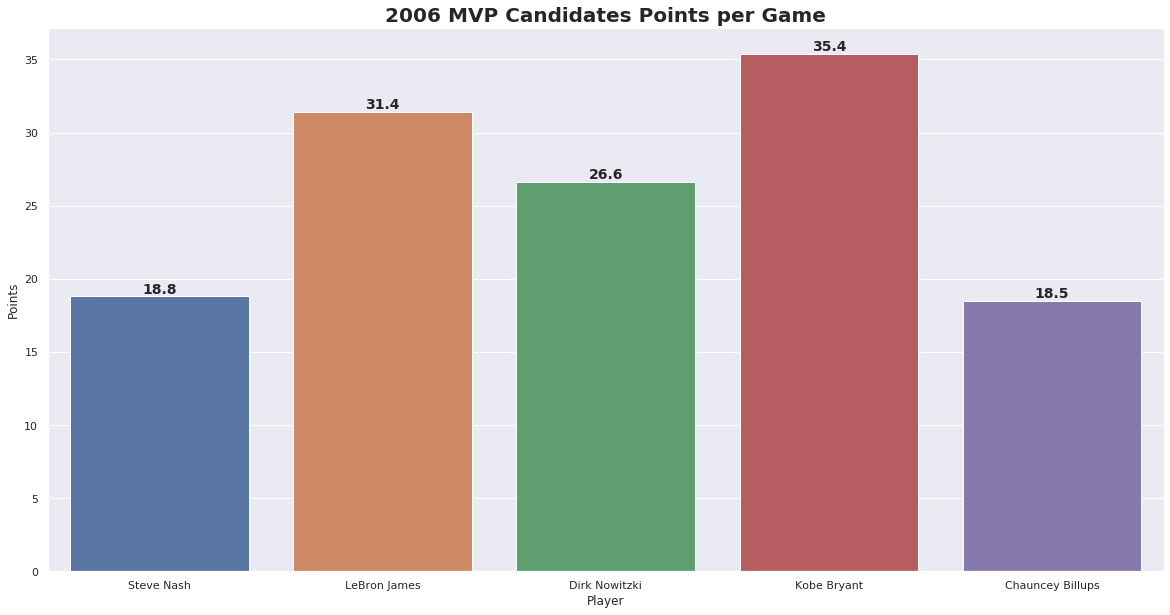

In [6]:
pts = pd.DataFrame()

year = 2006
for name in votes[year]['Player']:
    pts = pts.append({'Player': name, 'PTS': float(per_game[(name,year)]['PTS'])}, ignore_index=True)

plt.figure(figsize=(20,10))
p = sns.barplot(x='Player',y='PTS',data=pts)
ax = plt.gca()
for i, bar in enumerate(ax.patches):
    h = bar.get_height()
    ax.text(i, h+.5, '{}'.format(h), ha='center', va='center', fontweight='bold', size=14)
plt.title('2006 MVP Candidates Points per Game', fontweight="bold", fontsize=20)
plt.xlabel('Player')
plt.ylabel('Points')
plt.show()

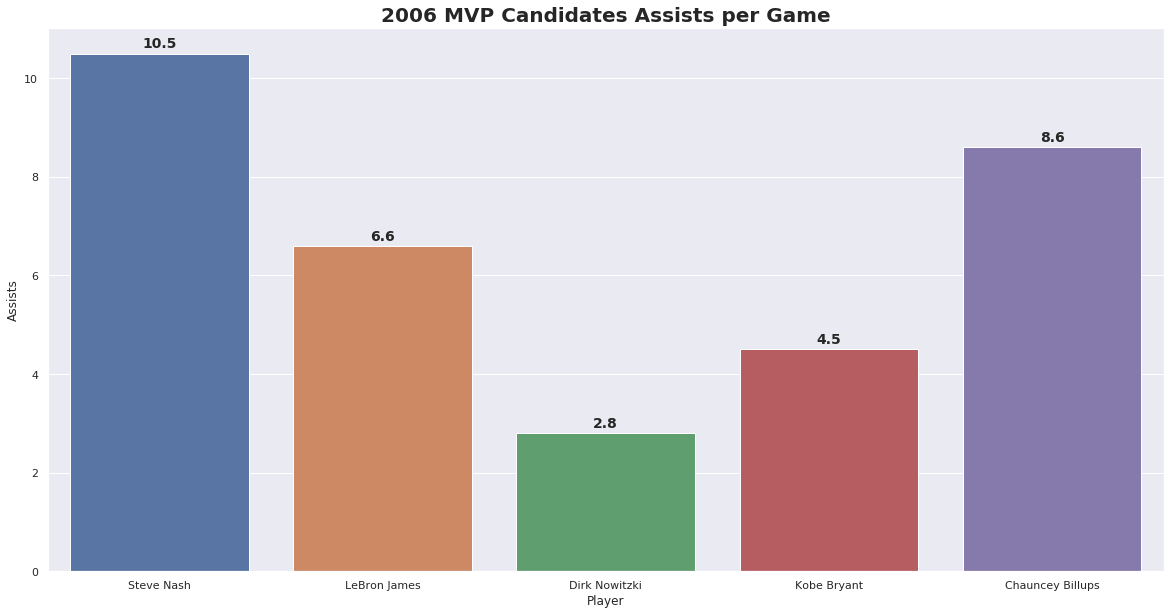

In [7]:
ast = pd.DataFrame()

year = 2006
for name in votes[year]['Player']:
    ast = ast.append({'Player': name, 'AST': float(per_game[(name,year)]['AST'])}, ignore_index=True)

plt.figure(figsize=(20,10))
p = sns.barplot(x='Player',y='AST',data=ast)
ax = plt.gca()
for i, bar in enumerate(ax.patches):
    h = bar.get_height()
    ax.text(i, h+.2, '{}'.format(h), ha='center', va='center', fontweight='bold', size=14)
plt.title('2006 MVP Candidates Assists per Game', fontweight="bold", fontsize=20)
plt.xlabel('Player')
plt.ylabel('Assists')
plt.show()

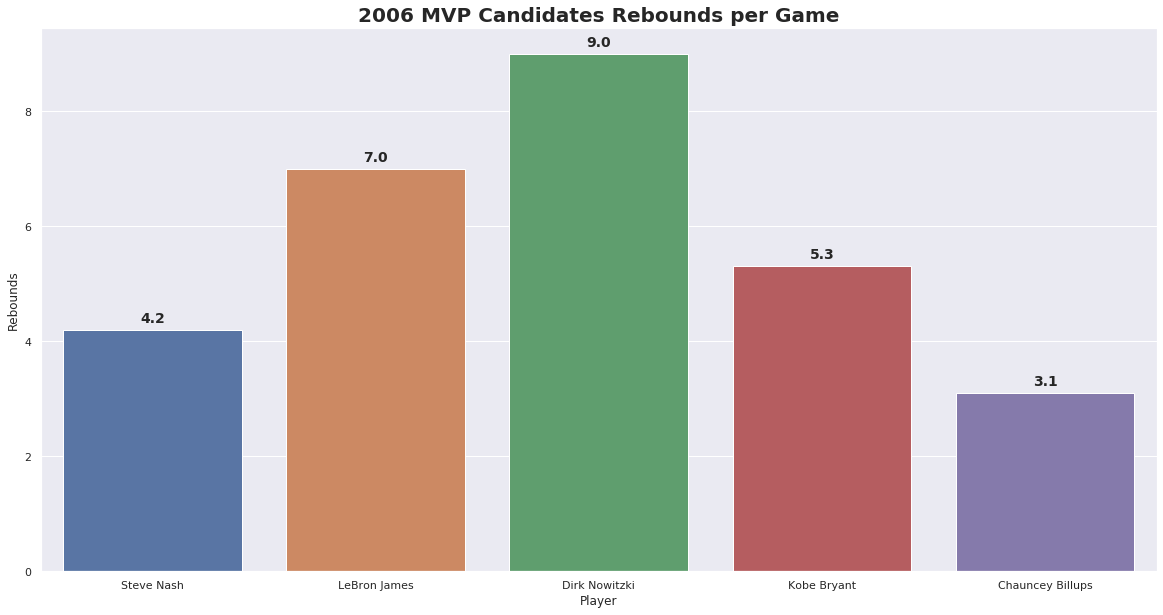

In [8]:
reb = pd.DataFrame()

year = 2006
for name in votes[year]['Player']:
    reb = reb.append({'Player': name, 'TRB': float(per_game[(name,year)]['TRB'])}, ignore_index=True)

plt.figure(figsize=(20,10))
p = sns.barplot(x='Player',y='TRB',data=reb)
ax = plt.gca()
for i, bar in enumerate(ax.patches):
    h = bar.get_height()
    ax.text(i, h+.2, '{}'.format(h), ha='center', va='center', fontweight='bold', size=14)
plt.title('2006 MVP Candidates Rebounds per Game', fontweight="bold", fontsize=20)
plt.xlabel('Player')
plt.ylabel('Rebounds')
plt.show()